✅ Data loaded: (284807, 30)
Random Forest Classification Report:

              precision    recall  f1-score   support

           0     0.9995    1.0000    0.9997     85295
           1     0.9717    0.6959    0.8110       148

    accuracy                         0.9994     85443
   macro avg     0.9856    0.8480    0.9054     85443
weighted avg     0.9994    0.9994    0.9994     85443

Isolation Forest Classification Report:

              precision    recall  f1-score   support

           0     0.9987    0.9989    0.9988     85295
           1     0.2899    0.2703    0.2797       148

    accuracy                         0.9976     85443
   macro avg     0.6443    0.6346    0.6393     85443
weighted avg     0.9975    0.9976    0.9975     85443



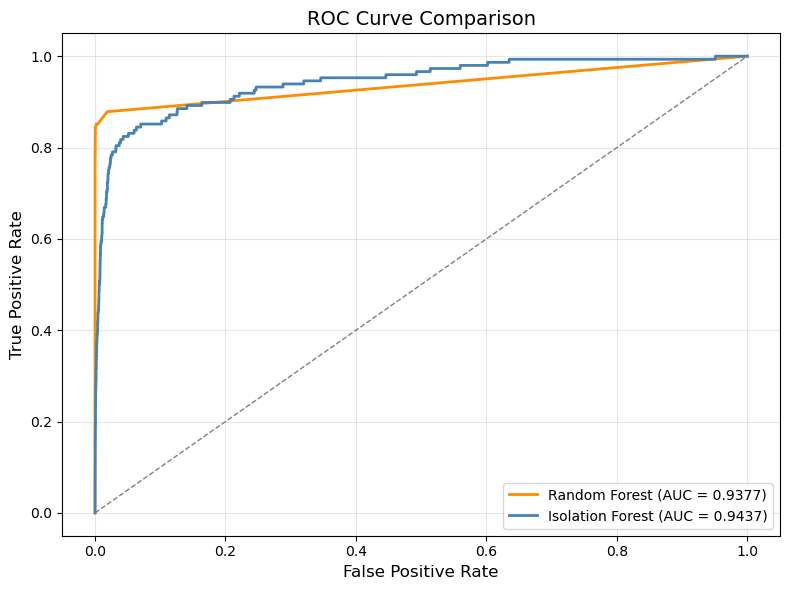

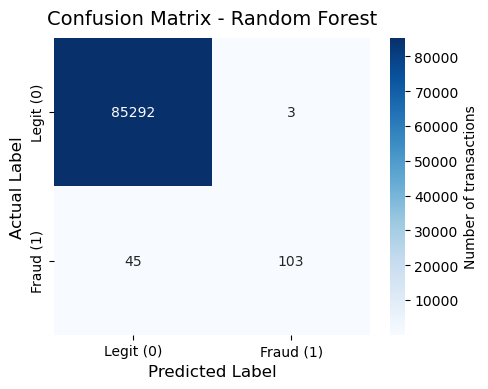

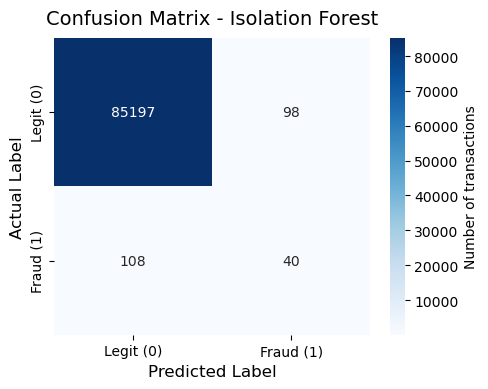

In [3]:
# =========================================
# IMPORTS
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import (
    roc_curve,
    auc,
    confusion_matrix,
    classification_report
)
from sklearn.model_selection import train_test_split

# =========================================
# LOAD DATA
# =========================================
# Replace this with the path to your cleaned CSV
data_path = "/Users/michealomotosho/Documents/EDUCATION DOCUMENTS/DATA SCIENCE SELF PROJECT/TransGuard-AI/data/Processed/transactions_cleaned.csv"

df = pd.read_csv(data_path)

# Target variable
y = df["Class"]

# Drop target and any other unwanted columns
X = df.drop(columns=["Class"])

# If your data has scaled columns, you might choose to keep those only:
if 'Amount_scaled' in X.columns:
    features_to_use = [col for col in X.columns if col.endswith('_scaled') or col.startswith('V')]
    X = X[features_to_use]

print("✅ Data loaded:", X.shape)

# =========================================
# TRAIN-TEST SPLIT
# =========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# =========================================
# RANDOM FOREST MODEL
# =========================================
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

# Predict probabilities (for ROC curve)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# Predict labels
rf_preds = (rf_probs >= 0.5).astype(int)

print("Random Forest Classification Report:\n")
print(classification_report(y_test, rf_preds, digits=4))

# =========================================
# ISOLATION FOREST MODEL
# =========================================
iso_model = IsolationForest(
    contamination=0.0017,  # roughly the fraud rate in credit card dataset
    random_state=42
)

iso_model.fit(X_train)

# Isolation Forest predicts:
#   -1 → anomaly → Fraud
#   1 → normal → Legit

iso_raw_preds = iso_model.predict(X_test)

# Convert to 0/1 labels
iso_preds = (iso_raw_preds == -1).astype(int)

# For ROC, we can use the decision function as a scoring value
iso_scores = iso_model.decision_function(X_test)

# Invert so that higher values mean fraud likelihood
iso_scores_inverted = -iso_scores

print("Isolation Forest Classification Report:\n")
print(classification_report(y_test, iso_preds, digits=4))

# =========================================
# PLOT ROC CURVES
# =========================================
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_iso, tpr_iso, _ = roc_curve(y_test, iso_scores_inverted)
roc_auc_iso = auc(fpr_iso, tpr_iso)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2,
         label=f"Random Forest (AUC = {roc_auc_rf:.4f})")

plt.plot(fpr_iso, tpr_iso, color='steelblue', lw=2,
         label=f"Isolation Forest (AUC = {roc_auc_iso:.4f})")

plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =========================================
# CONFUSION MATRIX HEATMAPS
# =========================================
def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['Legit (0)', 'Fraud (1)'],
        yticklabels=['Legit (0)', 'Fraud (1)'],
        cbar_kws={'label': 'Number of transactions'}
    )
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, pad=10)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# Random Forest confusion matrix
plot_conf_matrix(y_test, rf_preds, "Random Forest")

# Isolation Forest confusion matrix
plot_conf_matrix(y_test, iso_preds, "Isolation Forest")
